In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.special import erf
from scipy.signal import welch

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analyss_notebooks/../analysis_utils.py'>

In [4]:
def get_unnormalized_amps(data_files, 
                          noise=False,
                          no_search=False,
                          positive_pulse=True,
                          notch_freq=119000,
                          passband=(30000, 80000),
                          analysis_window_length=50000,
                          prepulse_window_length=50000,
                          search_window_length=250,
                          search_offset_length=20
                          ):
    amps = []
    for file in data_files:
        dtt, nn = utils.load_timestreams(file, ['D', 'G'])
        fs = int(np.ceil(1 / dtt))
        zz, dd = nn[0], nn[1]

        if notch_freq is not None:
            zz = utils.notch_filtered(zz, fs, f0=119000, q=50)

        bandpass_lb, bandpass_ub = passband
        zz_bp = utils.bandpass_filtered(zz, fs, bandpass_lb, bandpass_ub)

        trigger_level = positive_pulse * 0.5
        pulse_idx = utils.get_pulse_idx(dd, trigger_level, positive_pulse)
        
        if noise:
            # Fit noise away from the pulses
            pulse_idx = np.ceil(0.5 * (pulse_idx[:-1] + pulse_idx[1:])).astype(np.int64)

        for i, idx in enumerate(pulse_idx):
            if idx < prepulse_window_length:
                print('Skipping pulse too close to the beginning of file')
                continue
            if idx > (zz.size - analysis_window_length):
                print('Skipping pulse too close to the end of file')
                continue

            # 20241205: use a much narrower search window (25 indices; 5 us)
            # 20250211: change window length to 50000 indices and search window to 50 us
            # to be consistent with DM search
            window, f, f_lp, amp = utils.recon_pulse(idx, dtt, zz_bp, dd, 
                                               analysis_window_length, 
                                               prepulse_window_length, 
                                               search_window_length, 
                                               search_offset_length)

            if noise:
                if np.isnan(amp):
                    pass
                elif no_search:
                    # If no search, just take th middle value
                    amps.append(np.abs(f_lp[np.ceil(f_lp.size/2).astype(np.int64)])/1e9)
                else:
                    amps.append(amp)
            else:
                amps.append(amp)

    amps = np.asarray(amps)
    return amps

In [ ]:
data_file = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250828/20250829_m8e_2e-7mbar/20250829_dfg_m8e_200ns_20v_0.hdf5'

dtt, nn = utils.load_timestreams(data_file, ['D', 'G'])
fs = int(np.ceil(1 / dtt))
zz, dd = nn[0], nn[1]

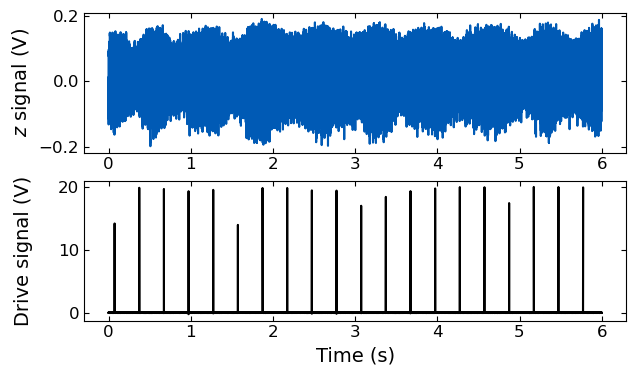

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(7, 4))

tt = np.arange(0, dtt*zz.size, dtt)
axes[0].plot(tt, zz, color='#005AB5')
axes[1].plot(tt, dd, 'k')

axes[1].set_xlabel('Time (s)')
axes[0].set_ylabel('$z$ signal (V)')
axes[1].set_ylabel('Drive signal (V)')

fig.align_labels()

In [46]:
zz_notched = utils.notch_filtered(zz, fs, f0=119000, q=50)
zz_notched_bp = utils.bandpass_filtered(zz_notched, fs, f_low=30000, f_high=80000, order=6)

Text(0, 0.5, 'PSD (V$^2$/Hz)')

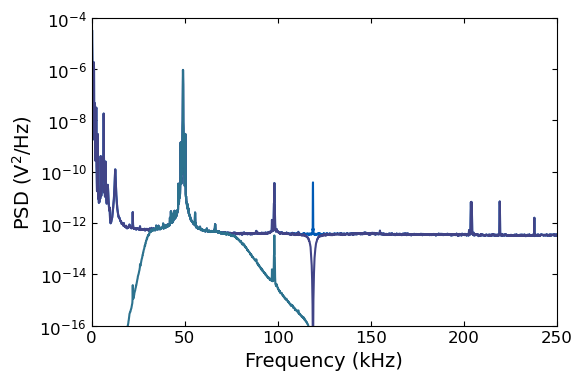

In [47]:
plt.figure(figsize=(6, 4))
ff, pp = welch(zz, fs, nperseg=2**16)
ff, pp_notched = welch(zz_notched, fs, nperseg=2**16)
ff, pp_notched_bp = welch(zz_notched_bp, fs, nperseg=2**16)


plt.plot(ff/1000, pp, color='#005AB5')
plt.plot(ff/1000, pp_notched)
plt.plot(ff/1000, pp_notched_bp)

plt.yscale('log')
plt.xlim(0, 250)
plt.ylim(1e-16, 1e-4)

plt.xlabel('Frequency (kHz)')
plt.ylabel(r'PSD (V$^2$/Hz)')

#### Sphere 20250828, 2e-7 mbar, 50 kHz

In [ ]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250828/20250829_m8e_2e-7mbar'
data_prefix = '20250829_dfg_m8e_200ns_'
voltages = [5, 10, 15, 20]

amps_all = []
amps_noise = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=119000,
                            passband=(30000, 80000),
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20
                            )

    if v == 5:
        amps_noise = get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=119000,
                        passband=(30000, 80000),
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20
                        )
            
    amps_all.append(np.asarray(amps))

5
10
15
20


In [139]:
pulse_amps_1e = np.asarray([34, 80, 127, 174])
pulse_amp = pulse_amps_1e * 8

bins = np.arange(0,3000, 50) / 29695.79112031468
hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise], bins=bins, noise=False, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]

Text(0, 0.5, 'Counts/(50 keV/$c$)')

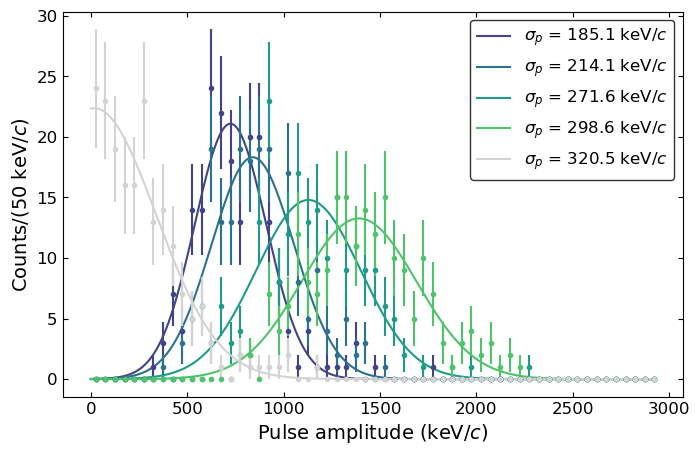

In [150]:
plt.figure(figsize=(8, 5))
xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 5))
for i in range(4):
    plt.errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

plt.errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][2]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

plt.legend(edgecolor='k')
plt.xlabel(r'Pulse amplitude (keV/$c$)')
plt.ylabel(r'Counts/(50 keV/$c$)')

#### Sphere 20250903, 5e-8 mbar, 50 kHz

In [152]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250830/20250903_p11e_5e-8mbar_50khz'
data_prefix = '20250903_dfg_p11e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

amps_all = []
amps_noise = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=119000,
                            passband=(30000, 80000),
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20
                            )

    if v == 5:
        amps_noise = get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=119000,
                        passband=(30000, 80000),
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20
                        )
            
    amps_all.append(np.asarray(amps))

2.5
5
Skipping pulse too close to the beginning of file
7.5
Skipping pulse too close to the end of file
10
12.5
15
17.5
Skipping pulse too close to the beginning of file
Skipping pulse too close to the end of file
20


Text(0, 0.5, 'Counts/(50 keV/$c$)')

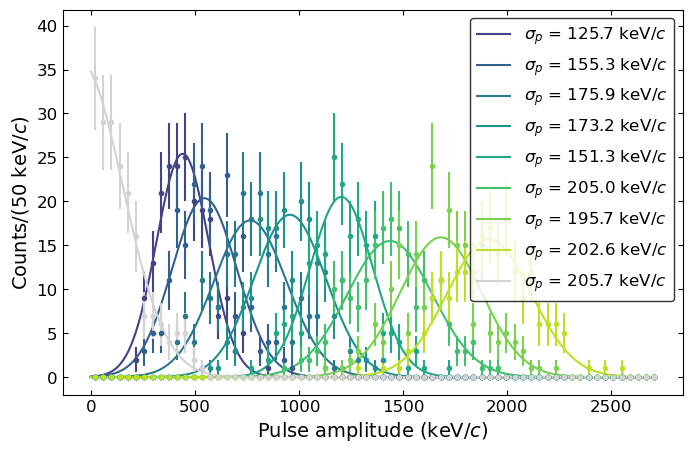

In [158]:
pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174])
pulse_amp = pulse_amps_1e * 11

bins = np.arange(0, 3500, 50) / 19622.875411392597
hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise], bins=bins, noise=False, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]

plt.figure(figsize=(8, 5))
xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
for i in range(8):
    plt.errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

plt.errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][2]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

plt.legend(edgecolor='k')
plt.xlabel(r'Pulse amplitude (keV/$c$)')
plt.ylabel(r'Counts/(50 keV/$c$)')

#### Sphere 20250903, 5e-8 mbar, 46 kHz

In [159]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250830/20250903_p11e_5e-8mbar_46khz'
data_prefix = '20250903_dfg_p11e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

amps_all = []
amps_noise = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=119000,
                            passband=(30000, 80000),
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20
                            )

    if v == 5:
        amps_noise = get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=119000,
                        passband=(30000, 80000),
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20
                        )
            
    amps_all.append(np.asarray(amps))

2.5
Skipping pulse too close to the beginning of file
5
7.5
Skipping pulse too close to the beginning of file
10
12.5
15
17.5
Skipping pulse too close to the beginning of file
Skipping pulse too close to the beginning of file
20


Text(0, 0.5, 'Counts/(50 keV/$c$)')

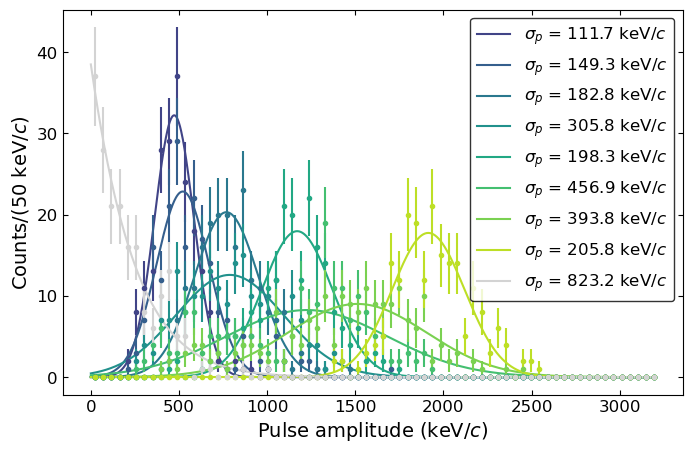

In [160]:
pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174])
pulse_amp = pulse_amps_1e * 11

bins = np.arange(0, 3500, 50) / 19622.875411392597
hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise], bins=bins, noise=False, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]

plt.figure(figsize=(8, 5))
xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
for i in range(8):
    plt.errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

plt.errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][2]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

plt.legend(edgecolor='k')
plt.xlabel(r'Pulse amplitude (keV/$c$)')
plt.ylabel(r'Counts/(50 keV/$c$)')

#### Sphere 20250904, 6e-8 mbar, 30 kHz

In [16]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250904/20250905_p11e_6e-8mbar_30khz_d93khz_0'
data_prefix = '20250905_dfg_p11e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

notch_freq = 93000
passband = (20000, 50000)

amps_all = []
amps_noise = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=notch_freq,
                            passband=passband,
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20
                            )

    if v == 2.5:
        amps_noise = get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=notch_freq,
                        passband=passband,
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20
                        )
            
    amps_all.append(np.asarray(amps))

2.5
Skipping pulse too close to the beginning of file
5
7.5
10
Skipping pulse too close to the beginning of file
12.5
Skipping pulse too close to the beginning of file
15
Skipping pulse too close to the beginning of file
17.5
20
Skipping pulse too close to the end of file


amp2keV: 66339.82182692927


Text(0, 0.5, 'Counts/(50 keV/$c$)')

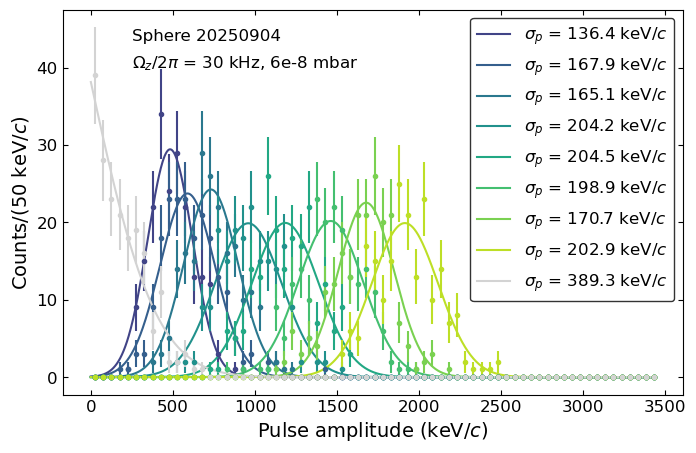

In [34]:
pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174])
pulse_amp = pulse_amps_1e * 11

bins = np.arange(0, 3500, 50) / 66137.72649175976
hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise], bins=bins, noise=False, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]
print('amp2keV:', amp2kev_all)

plt.figure(figsize=(8, 5))
xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
for i in range(8):
    plt.errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

plt.text(250, 43.5, 'Sphere 20250904', fontsize=12)
plt.text(250, 40, r'$\Omega_z / 2 \pi$ = 30 kHz, 6e-8 mbar', fontsize=12)
plt.errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][2]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

plt.legend(edgecolor='k')
plt.xlabel(r'Pulse amplitude (keV/$c$)')
plt.ylabel(r'Counts/(50 keV/$c$)')

#### Sphere 20250904, 6e-8 mbar, 30 kHz (another dataset, with drive at 73 kHz)

In [18]:
data_folder = r'/Volumes/LaCie/gas_collisions/pulse_calibration/sphere_20250904/20250905_p11e_6e-8mbar_30khz_d73khz_1'
data_prefix = '20250905_dfg_p11e_200ns_'
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

notch_freq = 73000
passband = (20000, 50000)

amps_all_1 = []
amps_noise_1 = None
for i, v in enumerate(voltages):
    print(v)
    dataset = data_prefix + f'{v}v'
    combined_path = os.path.join(data_folder, f'{dataset}*.hdf5')
    data_files = glob.glob(combined_path)

    amps = get_unnormalized_amps(data_files, 
                            noise=False,
                            no_search=False,
                            positive_pulse=True,
                            notch_freq=notch_freq,
                            passband=passband,
                            analysis_window_length=50000,
                            prepulse_window_length=50000,
                            search_window_length=250,
                            search_offset_length=20
                            )

    if v == 2.5:
        amps_noise_1 = get_unnormalized_amps(data_files, 
                        noise=True,
                        no_search=True,
                        positive_pulse=True,
                        notch_freq=notch_freq,
                        passband=passband,
                        analysis_window_length=50000,
                        prepulse_window_length=50000,
                        search_window_length=250,
                        search_offset_length=20
                        )
            
    amps_all_1.append(np.asarray(amps))

2.5
5
7.5
10
12.5
15
17.5
20


amp2keV: 56783.94837106449


Text(0, 0.5, 'Counts/(50 keV/$c$)')

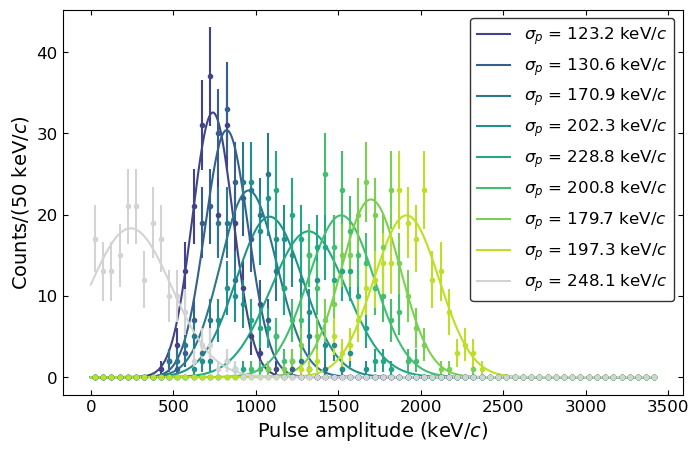

In [20]:
pulse_amps_1e = np.asarray([12, 34, 57, 80, 103, 127, 150, 174])
pulse_amp = pulse_amps_1e * 11

bins = np.arange(0, 3500, 50) / 56903.24590135632
hhs, bcs, gps = utils.fit_amps_gaus(amps_all_1, bins=bins, noise=False, return_bins=False)
hhs_noise, bcs_noise, gps_noise = utils.fit_amps_gaus([amps_noise_1], bins=bins, noise=False, return_bins=False)

amp2kevs = pulse_amp / np.asarray(gps).T[1]
amp2kev_all = amp2kevs[-1]
print('amp2keV:', amp2kev_all)

plt.figure(figsize=(8, 5))
xx = np.linspace(0, np.max(bcs[0]), 1000)

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
for i in range(8):
    plt.errorbar(bcs[i]*amp2kev_all, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev_all:.1f} keV/$c$', color=colors[i])

plt.errorbar(bcs_noise[0]*amp2kev_all, hhs_noise[0], yerr=np.sqrt(hhs_noise[0]), fmt='.', color='lightgrey')
plt.plot(xx*amp2kev_all, utils.gauss(xx, *gps_noise[0]), label=fr'$\sigma_p$ = {gps_noise[0][2]*amp2kev_all:.1f} keV/$c$', color='lightgrey')

plt.legend(edgecolor='k')
plt.xlabel(r'Pulse amplitude (keV/$c$)')
plt.ylabel(r'Counts/(50 keV/$c$)')